# Homework 9

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Sunday, November 11th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Michelle (Chia Chi) Ho, Jiejun Lu, Jiawen Tong**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special
from scipy.stats import norm
from scipy.stats import multivariate_normal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

In [3]:
# pymc3 and theano imports

import pymc3 as pm
from pymc3 import Normal, Binomial, sample, Model 
from pymc3.math import invlogit
import theano.tensor as T
from theano import shared

## Question 1: If I Sample the Works of the Brothers Gibb does that make me Bivariate Normal?

**coding required**

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \dots \vert $ is the matrix determinant operator.

In the following questions, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

1.1. Write down the two conditional distributions $f_{X_1 \vert X_2}, f_{X_2 \vert X_1}$

1.2. Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 

1.3. Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 

1.4. Plot a 2-d histogram of your samples, as well histograms of the $X_1$ and $X_2$ marginals.  Overlay on your histograms of the marginals a plot of the appropriate marginal density fitted with parameters derived from your marginal samples.

1.5. Present traceplots and autocorrelation plots for your marginal samples.  Is your choice of parameters justified? 

**Gratuitous Titular Reference**:  We've been accused of being overly cool in our music choices, so maybe it's time for something more [Normal](https://www.youtube.com/watch?v=jNJGl_jZTzc) (mixtape by Grime MC Merky ACE].  To take it a bit more old school, the Gibb brothers more commonly known as [The Beegees](https://en.wikipedia.org/wiki/Bee_Gees), were one of the most prominent bands in the 70s Disco movement (along with Donna Summer).  They're famous for songs like [More than a Woman](https://www.youtube.com/watch?v=fy0rYUvn7To), [To Love Somebody](https://www.youtube.com/watch?v=QHtGu0OGEpc) and of course [Stayin' Alive](https://www.youtube.com/watch?v=XfwQ_7xqO7Y).  Speaking of grimey London and mixups, [hold tight](https://www.urbandictionary.com/define.php?term=hold%20tight) former Arsenal fullback and top man Kieran Gibbs who provides a  great example of what happens when a referee tries Gibbs sampling but [samples the wrong distribution](https://youtu.be/FaZWMqOAveA?t=61).  [They all look the same, right](https://en.wikipedia.org/wiki/Cross-race_effect)?

### Answer 1.1

$$
\begin{align}
\left(
    \begin{array}{c}
        X_1  \\ 
        X_2  \\ 
    \end{array}
\right) 
&\sim \mathcal{N} 
\left(  
    \left[
    \begin{array}{c}
        \mu_1 \\ 
        \mu_2 \\ 
      \end{array} 
    \right],
    \left[
        \begin{array}{ccc}
            \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ 
            \rho \sigma_1 \sigma_2 & \sigma_2^2 \\ 
        \end{array} 
    \right]
\right)
= \mathcal{N} 
\left(  
    \left[
    \begin{array}{c}
        1 \\ 
        2 \\ 
      \end{array} 
    \right],
    \left[
        \begin{array}{ccc}
            4 & 1.2 \\ 
            1.2 & 4 \\ 
        \end{array} 
    \right]
\right)
. \\ \\
&\Longrightarrow \mu_1 = 1, \mu_2 = 2, \sigma_1 = 2, \sigma_2 = 2, \rho = 0.3 \\ \\
&\left( X_1 \vert X_2 = x_2 \right) \sim \mathcal{N} \left(\mu_1 + \rho \frac{\sigma_1}{\sigma_2} (x_2 - \mu_2), \sigma_1^2 (1 - \rho^2)\right) \\
&\left( X_2 \vert X_1 = x_1 \right) \sim \mathcal{N} \left(\mu_2 + \rho \frac{\sigma_2}{\sigma_1} (x_1 - \mu_1), \sigma_2^2 (1 - \rho^2)\right)
\end{align}
$$

---
### Answer 1.2 ~ 1.5

In [3]:
# parameters
mu_1, mu_2 = 1, 2
sigma_1, sigma_2 = 2, 2
rho = 0.3

# 1.2 gibbs sampler
def X1_given_X2(x2):
    m = mu_1 + rho * sigma_1 / sigma_2 * (x2 - mu_2)
    v = sigma_1**2 * (1 - rho**2)
    return norm.rvs(loc=m, scale=np.sqrt(v))

def X2_given_X1(x1):
    m = mu_2 + rho * sigma_2 / sigma_1 * (x1 - mu_1)
    v = sigma_2**2 * (1 - rho**2)
    return norm.rvs(loc=m, scale=np.sqrt(v))

def gibbs(p12, p21, N, start=[0,0], burnin=0.1, thin=2):
    # burnin: not keeping samples
    x1 = start[0]
    x2 = start[1]
    for i in range(int(burnin*N)):
        x1 = p12(x2) # sample x1|x2
        x2 = p21(x1) # sample x2|x1
        
    # after burnin
    samples = np.zeros((N, 2))
    samples[0, 0] = x1
    samples[0, 1] = x2
    for i in range(1, N):
        samples[i, 0] = p12(samples[i-1, 1]) # sample x1|x2
        samples[i, 1] = p21(samples[i, 0]) # sample x2|x1
    
    return samples[::thin]

In [4]:
# 1.3 draw samples & thinning
samples_Q1 = gibbs(X1_given_X2, X2_given_X1, 20000, burnin=0.1, thin=2)

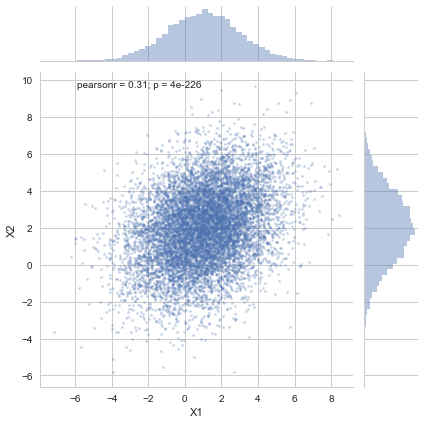

In [5]:
# 1.4 2D histogram in contourf plot
sns.jointplot('X1', 'X2', data=pd.DataFrame(samples_Q1, columns=['X1', 'X2']), cmap='Blues', alpha=0.3, s=5)
plt.tight_layout()

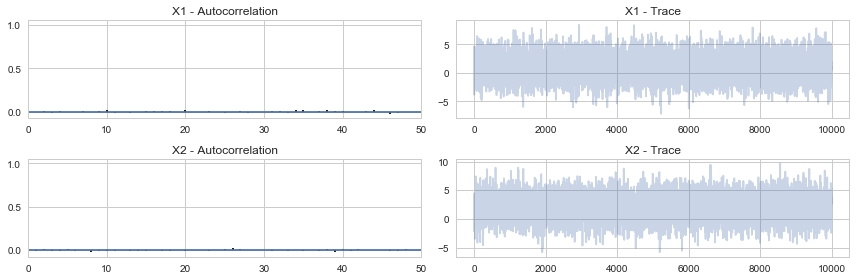

In [6]:
# 1.5 trace plots & autocorrelation plots of the marginal samples
def plot_autocorr_trace(samples, var_names, maxlags=50):
    fig, ax = plt.subplots(2,2, figsize=(12, 4))
    trace_X1 = samples[:, 0]
    trace_X2 = samples[:, 1]
    
    ax[0,0].acorr(trace_X1 - np.mean(trace_X1), normed=True, maxlags=maxlags);
    ax[0,0].set_xlim([0, maxlags])
    ax[0,0].set_title('{} - Autocorrelation'.format(var_names[0]))
    ax[0,1].plot(trace_X1, alpha=0.3)
    ax[0,1].set_title('{} - Trace'.format(var_names[0]))
    
    ax[1,0].acorr(trace_X2 - np.mean(trace_X2), normed=True, maxlags=maxlags);
    ax[1,0].set_xlim([0, maxlags])
    ax[1,0].set_title('{} - Autocorrelation'.format(var_names[1]))
    ax[1,1].plot(trace_X2, alpha=0.3)
    ax[1,1].set_title('{} - Trace'.format(var_names[1]))
    plt.tight_layout()

plot_autocorr_trace(samples_Q1, ['X1', 'X2'])

In [7]:
print('Sample mean: {}'.format(np.mean(samples_Q1, axis=0)))
print('Sample covariance matrix:\n{}'.format(np.cov(samples_Q1.T)))

Sample mean: [1.00059712 2.008732  ]
Sample covariance matrix:
[[4.04103085 1.269233  ]
 [1.269233   4.06996936]]


We choose thinning parameter as 2 and burn-in factor as 0.1, which gives us 10000 non-autocorrelated draws.

<div class="answer-separator">
------------------------
</div>

## Question 2: Through the Snap Lense of a Galaxy Man and Superman, Metropolis's Hastings has no disrupting Comet

**coding required**

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log \left[1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2 \right] $

where $\sigma_x = \sigma_y = \sqrt{10}$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

2.1. Plot the modified Beale's function.

2.2. Consider the following asymmetric function $q(x, y)$ as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

where $\gamma_1 = \beta$, $\gamma_2 = 1.5 \cdot \beta$, and $\beta=1$ 

*Note: x and y are the coordinates of the proposed step if we center the coordinate system in our current position.*

construct a Metropolis-Hastings algorithm along with a thinning parameter, burn-in factor and total number of iterations that allow you to produce  $N=25000$ non-autocorrelated samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. 

2.3. Plot a 2-d histogram of your samples, as well histograms of the $x$ and $y$ marginals. 

2.4. Present traceplots and autocorrelation plots for your marginal samples.

2.5. Experiment to determine how $\beta$ affects sampling by running your sampler with 5 $\beta$ values in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). Visualize the marginal samples, traceplot and autocorrelation plot for each $\beta$.

2.6. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 

2.7. Explain your results. What's the "best" value of $\beta$?

2.8.  Choose a symmetric proposal and construct a Metropolis algorithm along with a thinning parameter, burn-in factor and total number of iterations that allow you to produce  $N=25000$ non-autocorrelated samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. 

2.9. Plot a 2-d histogram of your samples from 2.8 as well histograms of the $x$ and $y$ marginals. 

2.10. Present traceplots and autocorrelation plots for your marginal samples.

2.11. How do the results compare to those from Metropolis-Hastings in 2.2 - 2.7?

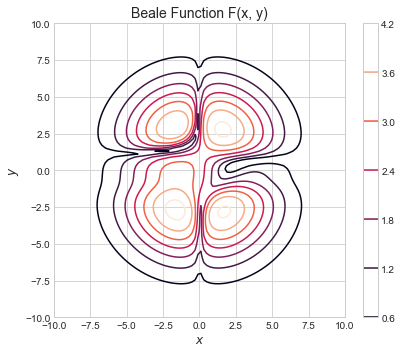

In [9]:
# 2.1 plot F
def F(x, y):
    a = np.exp(-(x**2/10 + y**2/10)/2)
    b = np.log(1 + (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2)
    return a*b

# domain
x_lin = np.linspace(-10, 10, 100)
y_lin = np.linspace(-10, 10, 100)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
F_grid = F(x_grid, y_grid)

# contour plot
plt.subplots(figsize=(6, 5))
plt.contour(x_grid, y_grid, F_grid)
plt.colorbar()
plt.title('Beale Function F(x, y)', fontsize=14)
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$y$', fontsize=12)
plt.tight_layout()

In [10]:
# 2.2 Metropolis Hasting Sampling
# q_draw ~ bivariate normal
def q_draw(current, m, c): 
    return multivariate_normal.rvs(mean=current+m, cov=c)

# q_pdf ~ bivariate normal
def q_pdf(new, current, m, c):
    return multivariate_normal.pdf(new, mean=current+m, cov=c)

def metropolis_hasting(p, q, q_draw, m, c, N, start, burnin=0.1, thin=2):
    samples = np.empty((N, 2))
    accepted = np.zeros((N,))
    x_prev = start
    
    for i in range(N):
        x_star = q_draw(x_prev, m, c)
        p_star = p(x_star[0], x_star[1])
        p_prev = p(x_prev[0], x_prev[1])
        pdf_ratio = p_star / p_prev
        proposal_ratio = q(x_prev, x_star, m, c) / q(x_star, x_prev, m, c)
        if np.random.uniform() < min(1, pdf_ratio*proposal_ratio):
            samples[i, :] = x_star
            x_prev = x_star
            accepted[i] = 1
        else:
            samples[i, :] = x_prev
        if i % 100 == 0:
            print('i = {}'.format(i), end='\r')
    
    # throw away burnin and thin
    samples = samples[int(burnin*N)::thin]
    accepted_count = np.sum(accepted[int(burnin*N)::thin])
            
    return samples, accepted_count/len(samples)

# draw samples from MH
beta = 1
m = np.array([0.1, 0.1])
c = np.array([[beta**2, 0], [0, (beta*1.5)**2]])

target_N = 25000
burnin = 0.1
thin = 50
N = int((target_N * thin) / (1 - burnin))
print('target_N = {}, N = {}'.format(target_N, N))
samples_Q2, accp_rate = metropolis_hasting(F, q_pdf, q_draw, m, c, N, [5, -5], burnin=burnin, thin=thin)
print('acceptance rate = {}'.format(accp_rate))

target_N = 25000, N = 1388888
acceptance rate = 0.75516


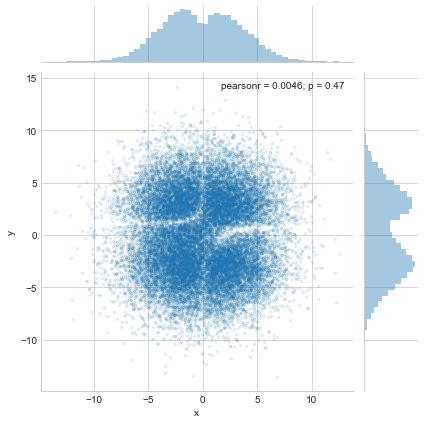

In [11]:
# 2.3 2D Density
sns.jointplot('x', 'y', pd.DataFrame(samples_Q2, columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)
plt.tight_layout()

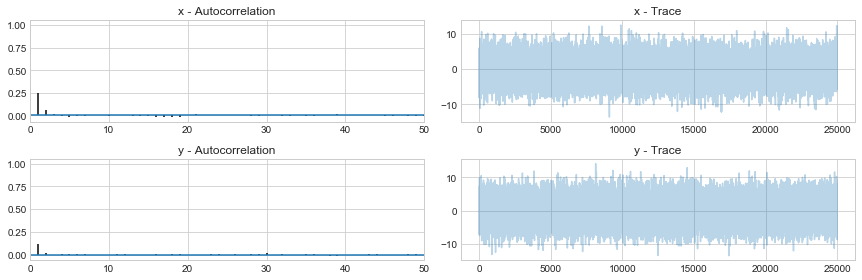

In [12]:
# 2.4 autocorrelation & trace plots
plot_autocorr_trace(samples_Q2, ['x', 'y'])

In [13]:
target_N = 25000
burnin = 0.1
thin = 2 
N = int((target_N * thin) / (1 - burnin))

betas = [0.1, 1, 5, 20, 40]
samples_Q2_arr = []
acceptance_arr = []

for b in betas:
    print('beta = {}'.format(b))
    m = np.array([0.1, 0.1])
    c = np.array([[b**2, 0], [0, (b*1.5)**2]])
    samples_Q2_b, accp_b = metropolis_hasting(F, q_pdf, q_draw, m, c, N, [5, -5], burnin=burnin, thin=thin)
    samples_Q2_arr.append(samples_Q2_b)
    acceptance_arr.append(accp_b)
    print('acceptance rate = {}'.format(accp_b))
    print('======================')

beta = 0.1
acceptance rate = 0.22228
beta = 1
acceptance rate = 0.75632
beta = 5
acceptance rate = 0.34512
beta = 20
acceptance rate = 0.03788
beta = 40
acceptance rate = 0.0104


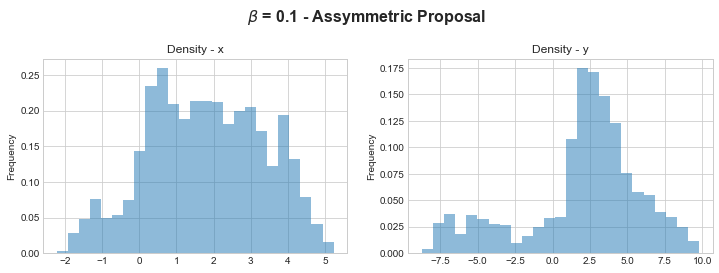

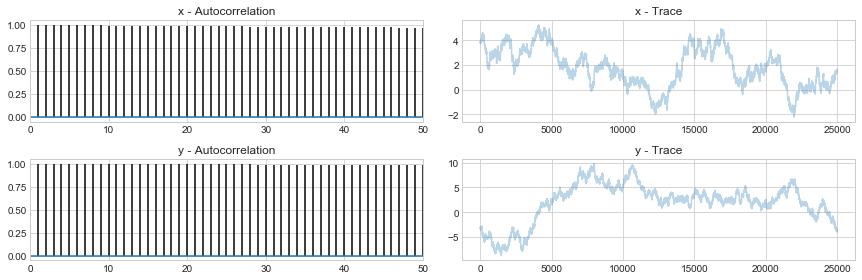

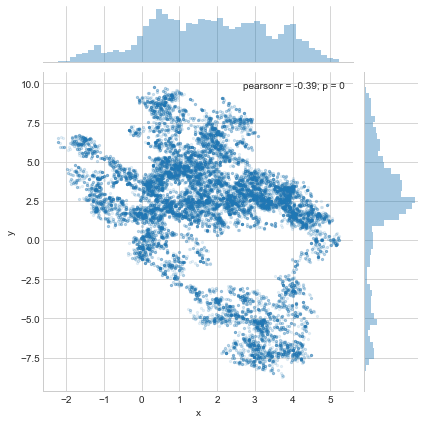

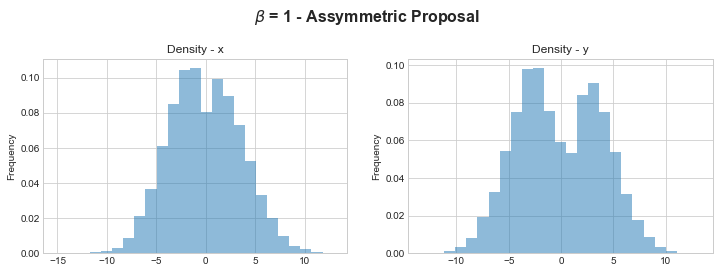

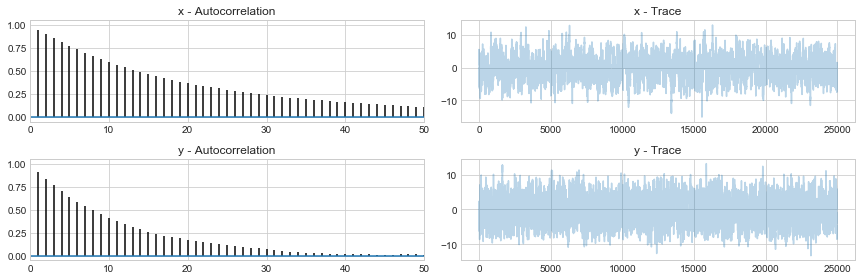

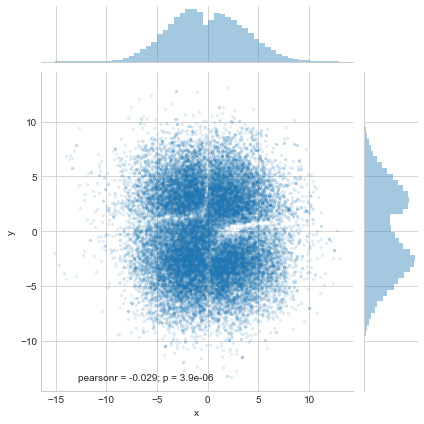

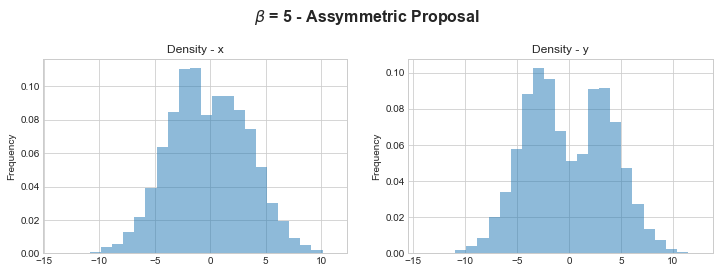

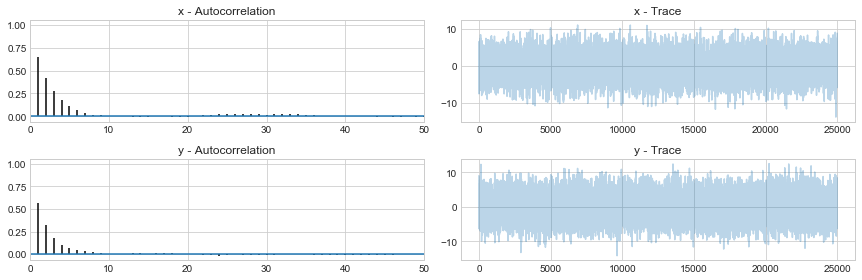

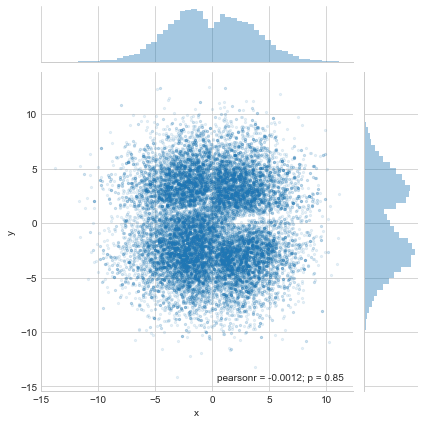

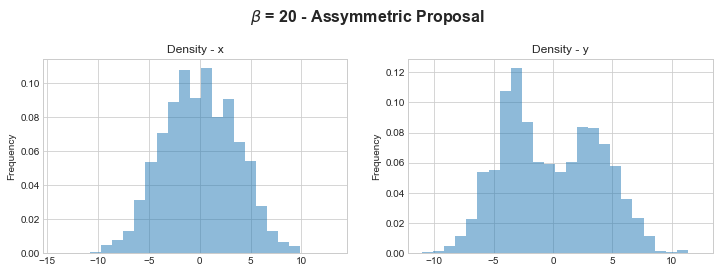

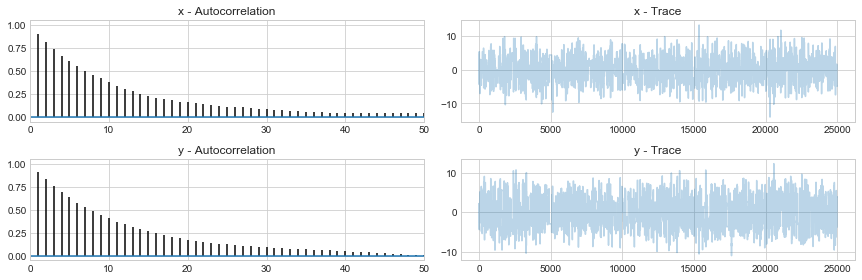

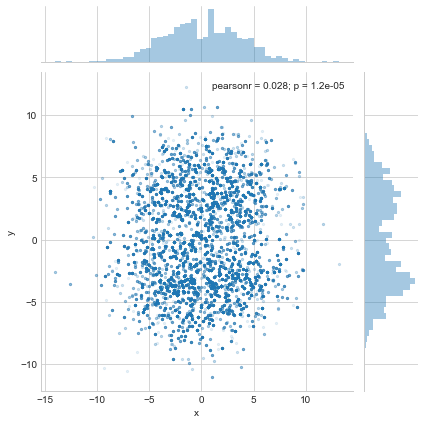

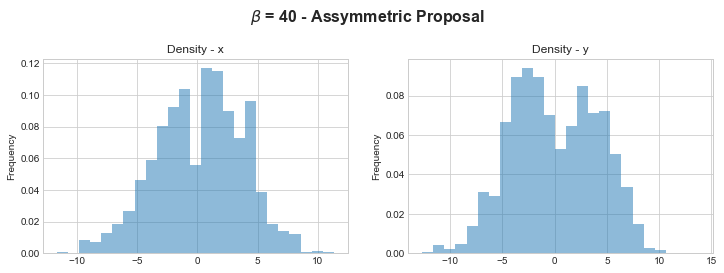

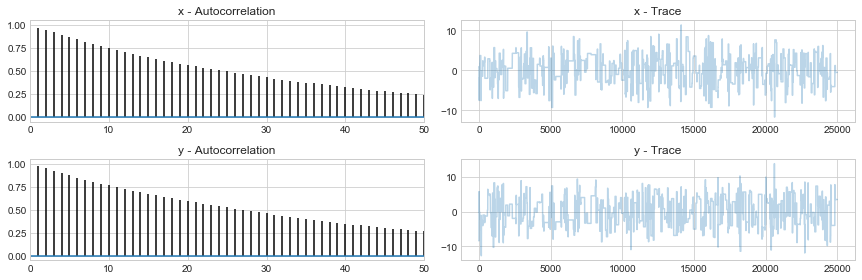

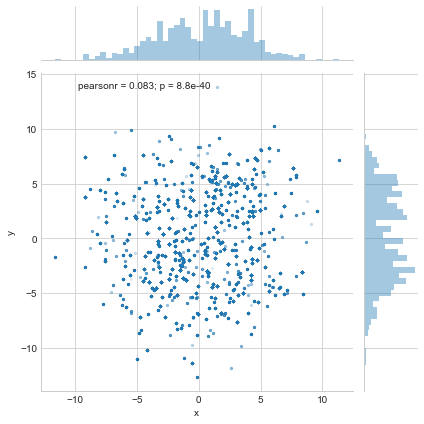

In [14]:
# 2.5 plots for different betas - asymmetric proposal
for i, b in enumerate(betas):
    # plotting title
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle(r'$\beta$ = {} - Assymmetric Proposal'.format(b), fontsize=16, weight='heavy')
    plt.subplots_adjust(top=0.8)
    
    # x, y marginal densities
    pd.Series(samples_Q2_arr[i][:, 0]).plot(kind='hist', density=True, alpha=0.5, bins=25, ax=ax[0], title='Density - x')
    pd.Series(samples_Q2_arr[i][:, 1]).plot(kind='hist', density=True, alpha=0.5, bins=25, ax=ax[1], title='Density - y')
    
    # autocorrelation & trace plots
    plot_autocorr_trace(samples_Q2_arr[i], ['x', 'y'])
    
    # 2D empirical density
    sns.jointplot('x', 'y', pd.DataFrame(samples_Q2_arr[i], columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)
    
    plt.tight_layout()


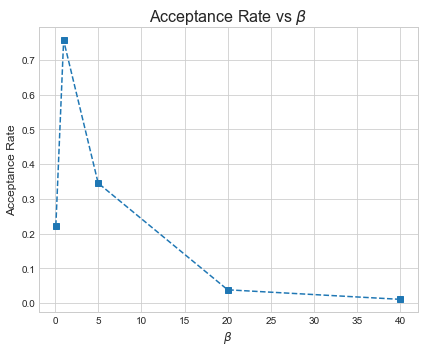

In [15]:
# 2.6 betas & accpetances
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(betas, acceptance_arr, 's--')
ax.set_xlabel(r'$\beta$', fontsize=12)
ax.set_ylabel('Acceptance Rate', fontsize=12)
ax.set_title(r'Acceptance Rate vs $\beta$', fontsize=16)
plt.tight_layout()

### Answer 2.7
Larger $\beta$ correspond to larger covariance terms in `q_proposal`:

$$\sim \mathcal{N} 
\left(  
    \left[
    \begin{array}{c}
        0.1 \\ 
        0.1 \\ 
      \end{array} 
    \right],
    \left[
        \begin{array}{ccc}
            \gamma_1^2 & 0 \\ 
            0 & \gamma_2^2 \\ 
        \end{array} 
    \right]
\right), \quad
\gamma_1 = \beta, \quad \gamma_2 = (1.5) \cdot \beta
$$

As $\beta$ has its effect in the variance terms, its test range should be spaced out approximately quadractically. We chose $\beta \in$ [0.1, 1, 5, 20, 40].

- Small $\beta$: high accpetance, low coverage; the very likely accpeted samples have high autocorrelation.

- Large $\beta$: low acceptance, high coverage; the accumulated samples were essentially duplicated and thus still high autocorrelation.

- Under the same thinning parameter = 2, **the best $\beta$ = 5:** 
> - the acceptance rate $\in (20\%, 50\%)$ 
> - procuded a set of samples that were not too hightly correlated, as shown in the autocorrelation plots

---

In [16]:
# 2.8 metropolis w/ symmetric proposal
def metropolis(p, q_draw, m, c, N, start, burnin=0.1, thin=2):
    samples = np.empty((N, 2))
    x_prev = start
    accepted = np.zeros((N,))
    
    for i in range(N):
        x_star = q_draw(x_prev, m, c)
        p_star = p(x_star[0], x_star[1])
        p_prev = p(x_prev[0], x_prev[1])
        pdf_ratio = p_star / p_prev
        if np.random.uniform() < min(1, pdf_ratio):
            samples[i, :] = x_star
            x_prev = x_star
            accepted[i] = 1
        else:
            samples[i, :] = x_prev
        if i % 100 == 0:
            print('i = {}'.format(i), end='\r')
            
    # throw away burnin and thin
    samples = samples[int(burnin*N)::thin]
    accepted_count = np.sum(accepted[int(burnin*N)::thin])
            
    return samples, accepted_count/len(samples)


In [20]:
# 2.8 metropolis - test for betas
target_N = 25000
burnin = 0.1
thin = 2
N = int((target_N * thin) / (1 - burnin))

betas = [0.1, 1, 5, 20, 40]
acceptance_sym_arr = []
samples_Q2_sym_arr = []

for b in betas:
    print('beta = {}'.format(b))
    m = np.array([0, 0])
    c = np.array([[b**2, 0], [0, (b*1.5)**2]])
    samples_Q2_b, accp_b = metropolis(F, q_draw, m, c, N, [5, -5], burnin=burnin, thin=thin)
    samples_Q2_sym_arr.append(samples_Q2_b)
    acceptance_sym_arr.append(accp_b)
    print('acceptance rate = {}'.format(accp_b))
    print('======================')
    

beta = 0.1
acceptance rate = 0.97472
beta = 1
acceptance rate = 0.78224
beta = 5
acceptance rate = 0.34728
beta = 20
acceptance rate = 0.0406
beta = 40
acceptance rate = 0.0112


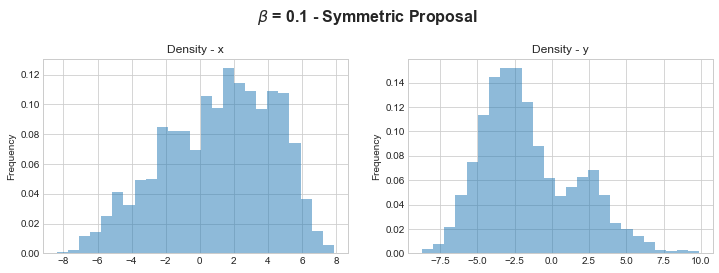

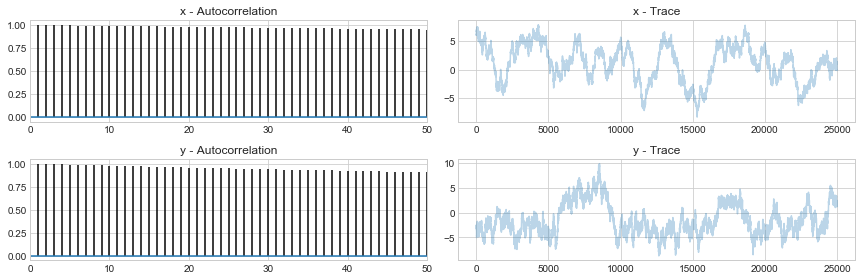

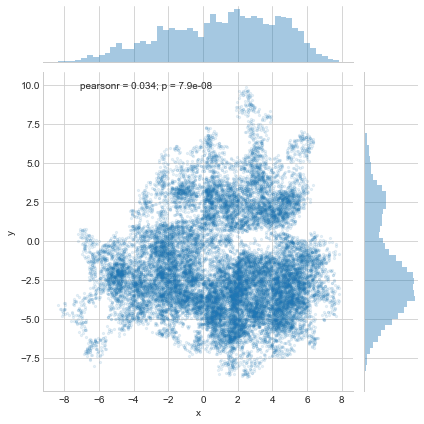

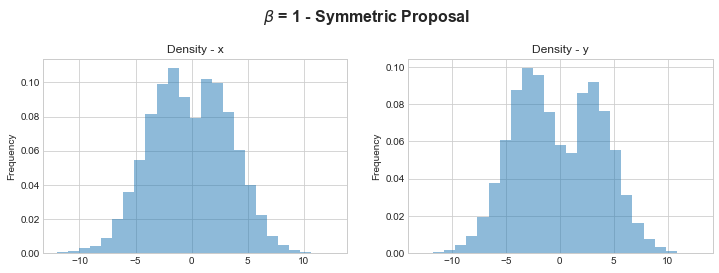

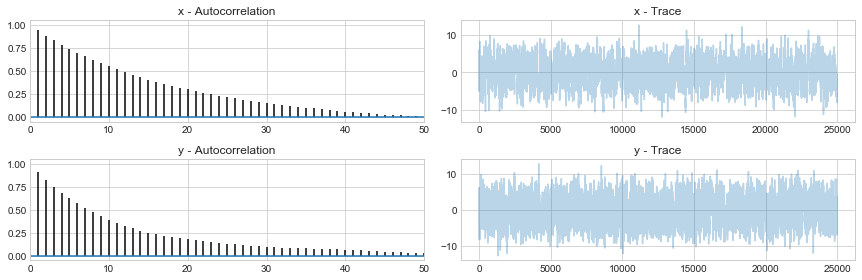

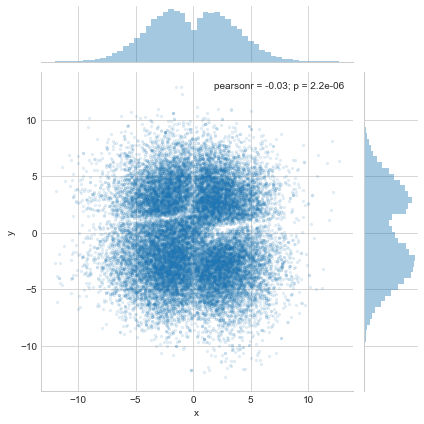

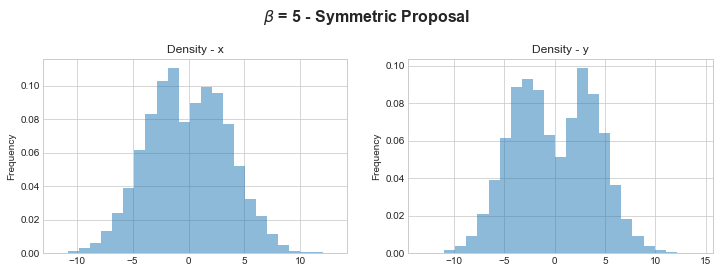

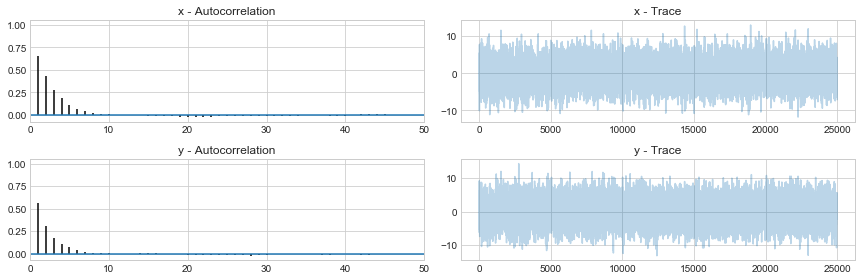

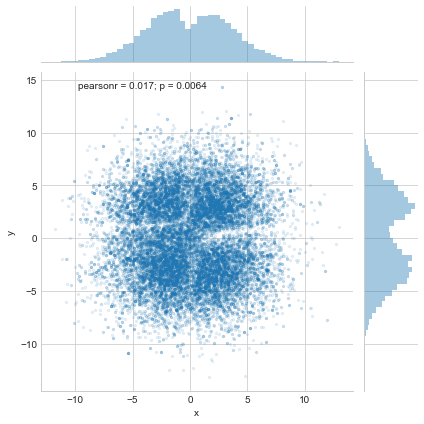

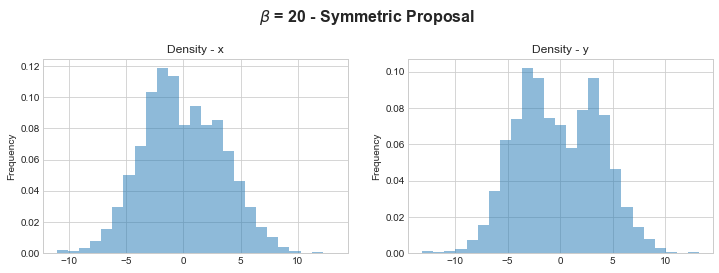

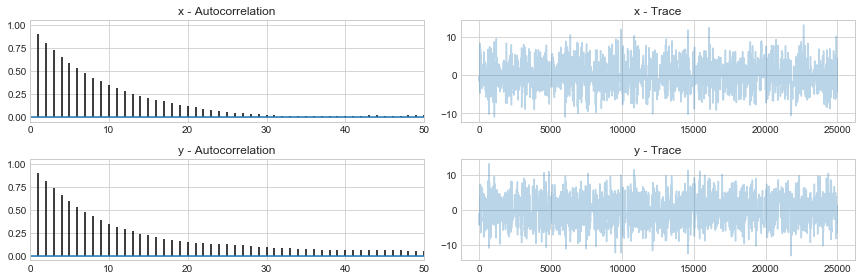

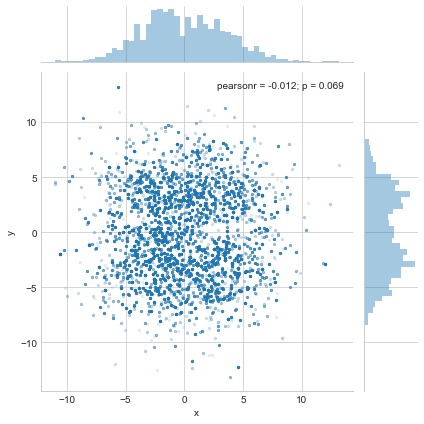

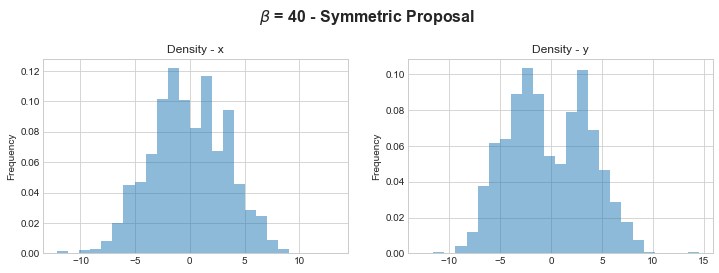

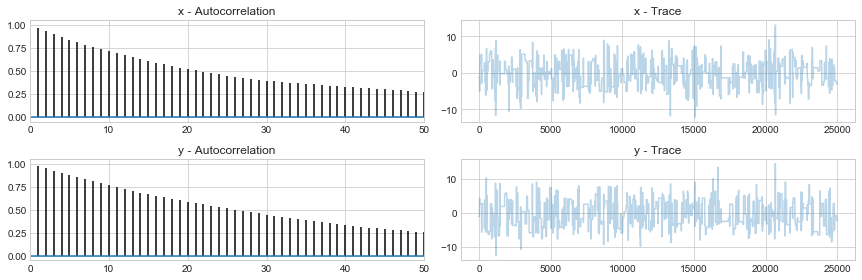

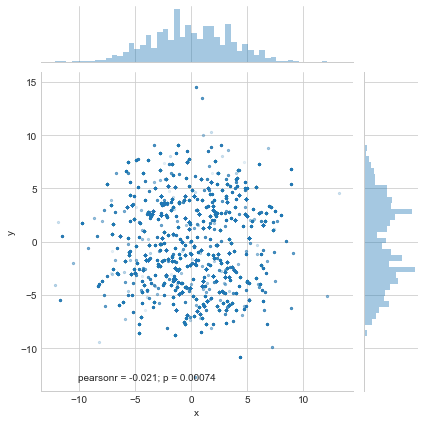

In [21]:
# plots for different betas - symmetric proposal
for i, b in enumerate(betas):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle(r'$\beta$ = {} - Symmetric Proposal'.format(b), fontsize=16, weight='heavy')
    plt.subplots_adjust(top=0.8)
    
    # x, y marginal densities
    pd.Series(samples_Q2_sym_arr[i][:, 0]).plot(kind='hist', density=True, alpha=0.5, bins=25, ax=ax[0], title='Density - x')
    pd.Series(samples_Q2_sym_arr[i][:, 1]).plot(kind='hist', density=True, alpha=0.5, bins=25, ax=ax[1], title='Density - y')
    
    # autocorrelation & trace plots
    plot_autocorr_trace(samples_Q2_sym_arr[i], ['x', 'y'])
    
    # 2D empirical density
    sns.jointplot('x', 'y', pd.DataFrame(samples_Q2_sym_arr[i], columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)
    
    plt.tight_layout()

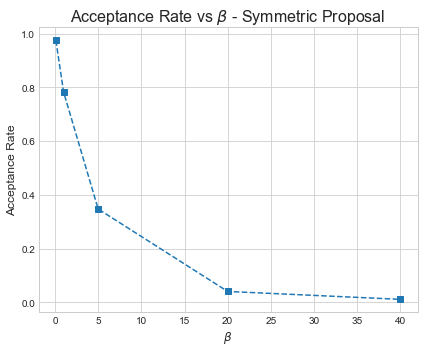

In [22]:
# 2.8 symmetric q_proposal, betas & accpetances
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(betas, acceptance_sym_arr, 's--')
ax.set_xlabel(r'$\beta$', fontsize=12)
ax.set_ylabel('Acceptance Rate', fontsize=12)
ax.set_title(r'Acceptance Rate vs $\beta$ - Symmetric Proposal', fontsize=16)
plt.tight_layout()

In [23]:
# 2.9 draw samples from metropolis - symmetric proposal
# best beta = 5
print('beta = 5')
target_N = 25000
burnin = 0.1
thin = 50
N = int((target_N * thin) / (1 - burnin))

m = np.array([0, 0])
c = np.array([[5**2, 0], [0, (5*1.5)**2]])
samples_Q2_sym, accp_sym = metropolis(F, q_draw, m, c, N, [5, -5], burnin=burnin, thin=thin)
print('acceptance rate = {}'.format(accp_sym))
print('======================')

beta = 5
acceptance rate = 0.3468


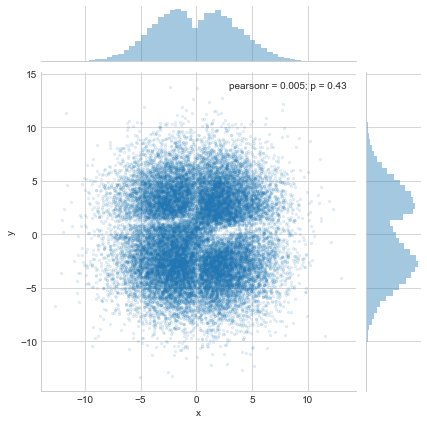

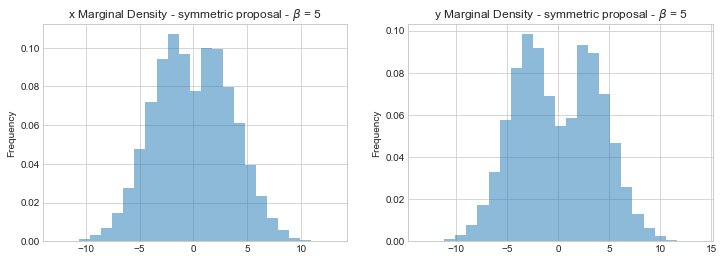

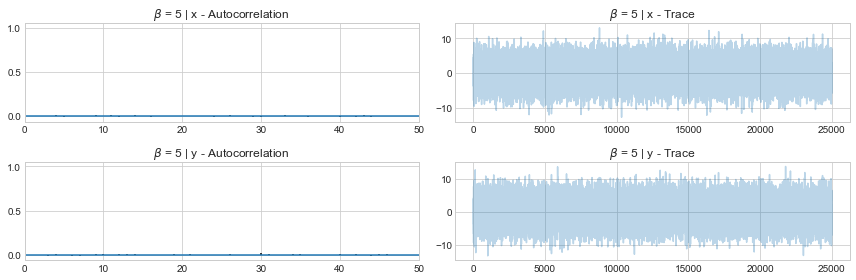

In [24]:
# 2.9 2D density - symmetric proposal
sns.jointplot('x', 'y', pd.DataFrame(samples_Q2_sym, columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)

# 2.9 x, y marginal densities - symmetric proposal
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(samples_Q2_sym[:, 0]).plot(kind='hist', density=True, alpha=0.5, bins=25, ax=ax[0], 
                                   title=r'x Marginal Density - symmetric proposal - $\beta$ = 5')
pd.Series(samples_Q2_sym[:, 1]).plot(kind='hist', density=True, alpha=0.5, bins=25, ax=ax[1], 
                                   title=r'y Marginal Density - symmetric proposal - $\beta$ = 5')

# 2.10 autocorrelation & trace plots of the marginal samples - symmetric distribution
plot_autocorr_trace(samples_Q2_sym, [r'$\beta$ = 5 | x', r'$\beta$ = 5 | y'])

plt.tight_layout()

### Answer 2.11

Compared to **metropolis hasting** using the asymmetric bivariate normal `q_proposal` centered at the shifted current sample $(x + 0.1, y + 0.1)$, **metropolis** with the symmetric proposal centered at $(x, y)$ had almost the same performance for most $\beta$'s. The improvement in coverage was most observable with small variances (i.e., $\beta = 0.1$) because in this case the very likely accpeted new samples are concentrated around the un-shifted current sample $(x, y)$. The difference was insignificant for larger $\beta$'s, and the best $\beta$ was still 5.

---

**Gratuitous Titular References**:  [Snap](https://www.snapchat.com/) obviously has [lenses](https://www.reddit.com/r/SnapLenses/) which you may (or [may not](https://forum.xda-developers.com/note5/help/snapchat-lenses-t3202082)) be able to see on your [Galaxy](https://www.samsung.com/us/mobile/galaxy/) ... [far far away](https://en.wikipedia.org/wiki/Star_Wars_opening_crawl)...  

[Man and Superman](https://en.wikipedia.org/wiki/Man_and_Superman) is an important play by the notable Irish playright George Bernard Shaw.  

The [Bayeux Tapestry](https://en.wikipedia.org/wiki/Bayeux_Tapestry) is a historically important embroidered tapestry detailing the Norman conquest of Britain and in particular the [Battle of Hastings](https://en.wikipedia.org/wiki/Battle_of_Hastings), the decisive Norman victory that marked the beginning of Norman rule over England.  The tapestry is historically the first known depiction of [Halley's comet](https://en.wikipedia.org/wiki/Halley%27s_Comet).  

[Metropolis]() is most famous as the the fictional city patrolled by the DC superhero [Superman]() whose streaking figure is the closest thing to a comet the denizens of Metropolis see in their celestial firmament.  Learn all about it [Metropolis](https://www.dccomics.com/blog/2018/01/30/announcing-metropolis-dcs-newest-live-action-tv-series), the newest live action tv series in the DC-verse (coming in 2019) which features Lois Lane and Lex Luthor but no Superman.

[The Expanse](https://www.syfy.com/theexpanse) and [Krypton](https://www.syfy.com/krypton) are watchable too.

<div class="answer-separator">
------------------------
</div>

## Question 3 - Assay Assay Bio you don't seem to be Apprehendin' the general Gist...

**coding required**

#### Bioassay

This question follows an example from Gelman's "Bayesian Data Analysis". It will walk you through using `pymc3`. Keep a browser tab open to the pymc3 API docs...you will need them.

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

In this experiment, various drug doses are administered to animals and a binary outcome (death) is noted. There are 4 groups of 5 animals each, different doses administered, and deaths recorded. We construct a model for $\theta$ the binomial probabiliy of death, as a regression on dose through the logit$^{-1}$ function with two parameters (see below). We set imprecise normal priors on the regression coefficients, and pass the linear regression through the inverse logit function into a binomial likelihood.

We'll enter the data here. One subtlety: we'll need to create a "shared" theano array so that we can compute posterior predictives on a grid later.

In [4]:
# Use a theano shared variable to be able to exchange the data the model runs on

# Log dose in each group
log_dose = np.array([-.86, -.3, -.05, .73])

# Let's make this a theano shared variable so that we can make predictions for new values later
log_dose_shared = shared(log_dose)

# Sample size in each group
n = 5 * np.ones(4, dtype=int)

# The sample size has to be a shared variable too
n_shared = shared(n)

# Outcomes
deaths = np.array([0, 1, 3, 5])

The likelihood, since we have a success/fail experiment, is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Binomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

The prior $p(\alpha, \beta)$ is a product of independent priors on $\alpha$ and $\beta$.  Considering the likelihood and the prior, the posterior is then: 

$$ 
\begin{align*}
p(\alpha, \beta \vert y) &\propto p(\alpha)p(\beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) \\
                         &= p(\alpha)p(\beta)\prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} 
\end{align*}
$$

#### Setting up the model in PyMC3

The first step is to specify the probabilistic model in PyMC3. We'll assume the prior $p(\alpha, \beta)$ splits into independent priors for $\alpha$ and $\beta$:

$$p(\alpha, \beta) = p(\alpha) \times p(\beta), $$

and further assume identical non-informative normal $N(0, 100$) priors on both.

In [5]:
with Model() as bioassay_model:

    # Logit-linear model parameters
    alpha = pm.Normal('alpha', 0, sd=100)
    beta = pm.Normal('beta', 0, sd=100)

    # Calculate probabilities of death
    theta = pm.Deterministic('theta', invlogit(alpha + beta * log_dose_shared))

    # Data likelihood
    obs_deaths = pm.Binomial('obs_deaths', n=n_shared, p=theta, observed=deaths)

pm.model_to_graphviz above should return an output like the following:

![](https://d1b10bmlvqabco.cloudfront.net/attach/jlo4e4ari3r4wd/j9vjyzv62x149/jo39alg3bjeq/bio_assay.png)

At the model-specification stage (before the data are observed), $\alpha$, $\beta$, $\theta$, and $y$ (the observed number of deaths) are all random variables. Then we observe $y$ and condition on these observations.




3.1. ***Verifying Installation***:  Try and reproduce the model graph in the image above by running all the above code cells provided in **Question 3**.  A currect run means that theano was installed properly as a dependency for pymc3.

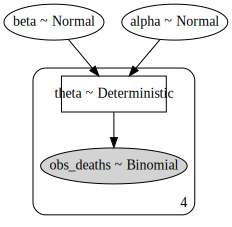

In [6]:
# 3.1
pm.model_to_graphviz(bioassay_model)

3.2. ***Finding MAP point estimates***:  the maximum a posteriori (MAP) estimate for a model is the mode of the posterior distribution and is generally found using numerical optimization methods. PyMC3 provides this functionality with the `pm.find_MAP`  function. By default, ```find_MAP``` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm. Use it to find the MAP of the parameters. Notice that `pymc3` will propagate the MAP to the deterministic $\theta$ variable.

In [7]:
# 3.2
map_params = pm.find_MAP(model=bioassay_model)
map_params

logp = -13.034, ||grad|| = 0.00043389: 100%|██████████| 14/14 [00:00<00:00, 151.65it/s]  


{'alpha': array(0.84375669),
 'beta': array(7.73020461),
 'theta': array([0.00300575, 0.18613766, 0.61236076, 0.99847891])}

3.3. Sample from the `bioassay_model` model by using the `pm.sample` function by passing`pm.Metropolis()` stepper as the `step` parameter  and pass in the MAP estimate as a starting point using the 'start' parameter. Generate 50,000 samples. You will see a  warning message --`The number of effective samples is smaller than 10% for some parameters`.  For the purposes of this homework ignore the warning message.

In [8]:
# 3.3
with bioassay_model:
    trace = pm.sample(50000, step=pm.Metropolis(), start=map_params)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:39<00:00, 2530.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


3.4. Remove a burnin period of the first 40% of the samples from the trace, then use `pm.traceplot` and `pm.plot_posterior` to visualize the traces and the marginal posteriors of our parameters, as well as a propagated $\theta$ set for our probabilities. Also plot the joint-posterior of our parameters (using seaborn's `sns.kdeplot`, for example). Finally, use `pm.summary` to output a summary of our parameter inferences.

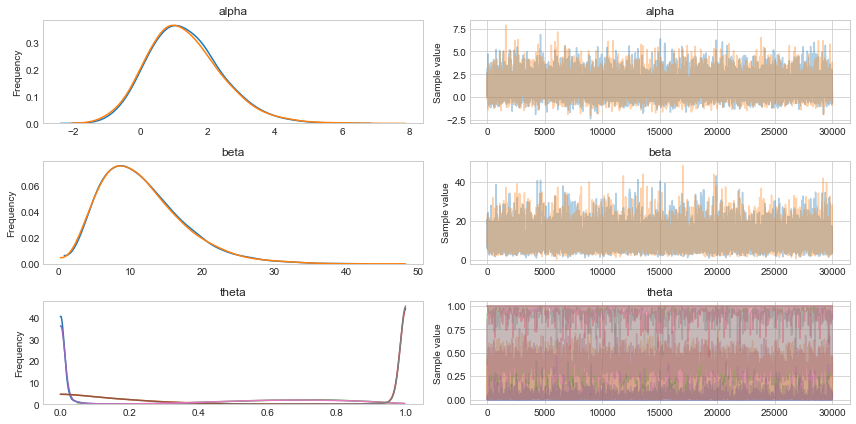

In [9]:
# 3.4
pm.traceplot(trace[int(0.4*50000)::])
plt.tight_layout()

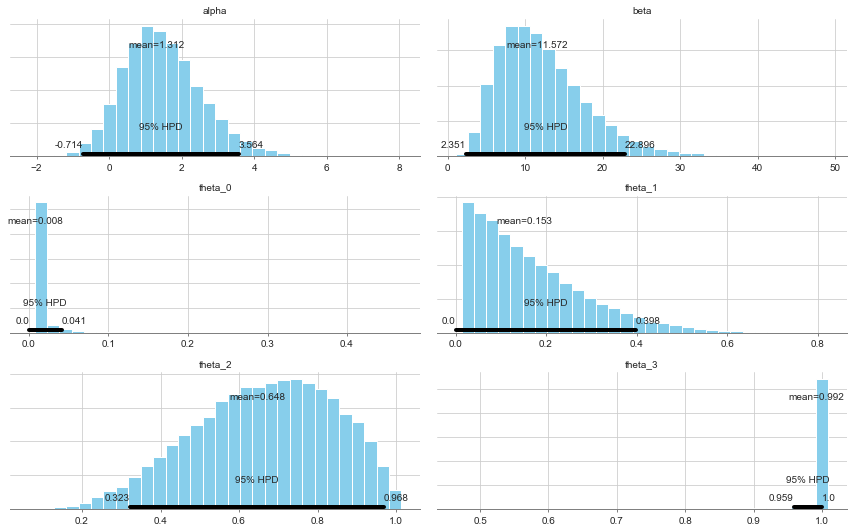

In [11]:
pm.plot_posterior(trace[int(0.4*50000)::])
plt.tight_layout()

(60000, 2)


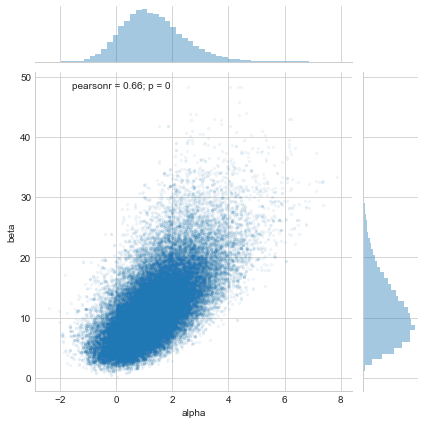

In [12]:
trace_alpha_beta = np.array([
    trace[int(0.4*50000)::]['alpha'],
    trace[int(0.4*50000)::]['beta']
]).T

df_alpha_beta = pd.DataFrame(trace_alpha_beta, columns=['alpha', 'beta'])
print(df_alpha_beta.shape)

# sns.kdeplot(df_alpha_beta['alpha'], df_alpha_beta['beta'], cmap='Blues')
sns.jointplot(x='alpha', y='beta', data=df_alpha_beta, cmap='Blues', alpha=0.05, s=5)
plt.tight_layout()

In [13]:
pm.summary(trace[int(0.4*50000)::])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.312009,1.106131,0.015280,-7.140327e-01,3.563967,4569.850907,1.000153
beta,11.572359,5.765925,0.086486,2.350875e+00,22.896020,3818.892633,1.000041
theta__0,0.007803,0.023765,0.000203,2.340662e-16,0.040987,11751.931792,1.000078
theta__1,0.152677,0.123997,0.001058,6.648851e-06,0.397741,13095.419006,0.999984
theta__2,0.647722,0.177376,0.002097,3.228083e-01,0.968052,6403.189042,1.000327
theta__3,0.992355,0.027175,0.000254,9.586000e-01,1.000000,10508.354146,1.000087


3.5. Use `pm.autocorrplot` to plot the autocorrelations from our sampler. What happens when you thin our trace to every fifth sample?

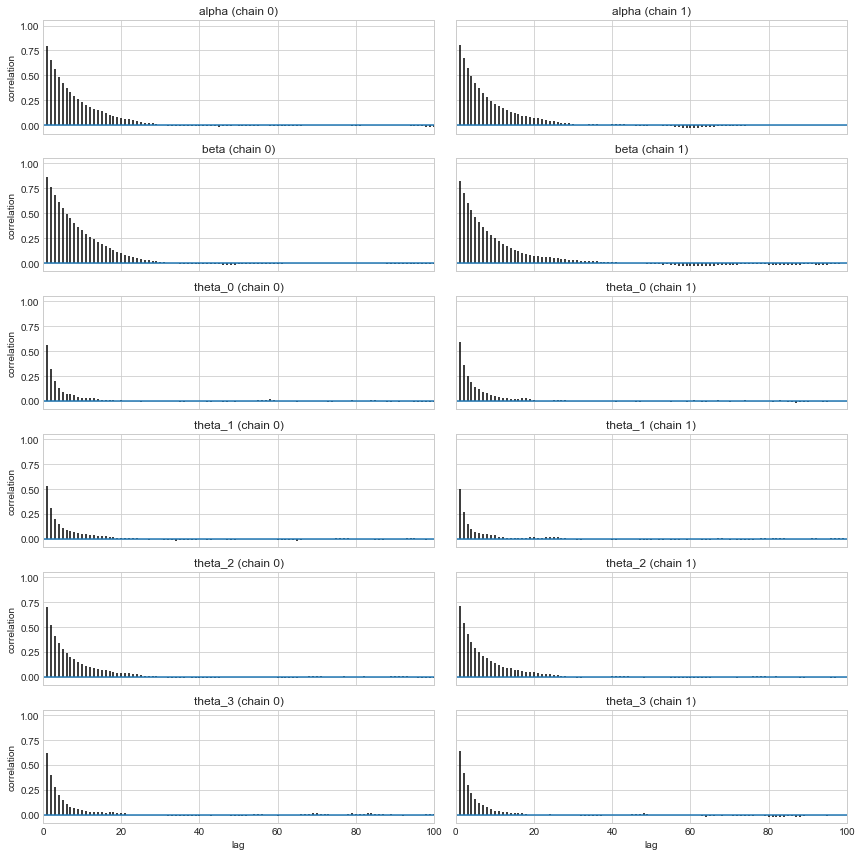

In [14]:
# 3.5 without thining
pm.autocorrplot(trace[int(0.4*50000)::])
plt.tight_layout()

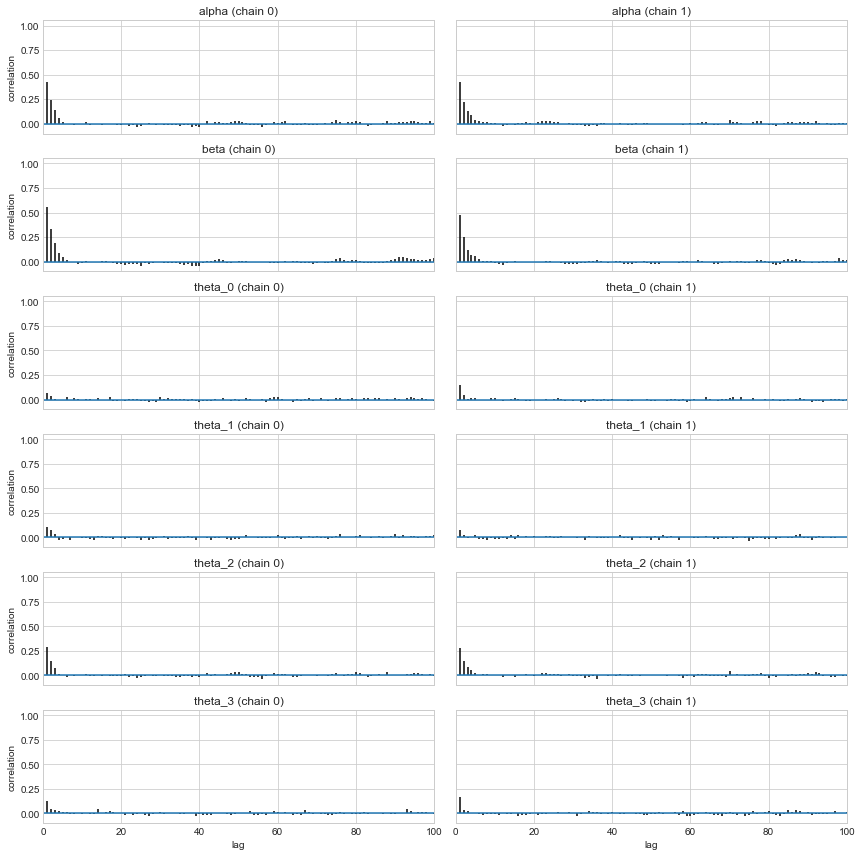

In [15]:
# 3.5 with thining = 5
pm.autocorrplot(trace[int(0.4*50000)::5])
plt.tight_layout()

### Answer 3.5

With thinning = 5, the autocorrelations for each parameter decreased.

---

***Checking convergence with chains***: It is in general impossible to guarantee that a MCMC has indeed reached convergenge,  but convergence diagnostics can detect lack of convergence.

An *ad hoc* method to detect lack of convergence involves plotting the traces of chains initialized with different starting conditions. We can run more than one chain using the argument `njobs` of the  `sample` function (pymc3 runs 2 by default). If convergence has occurred, we would expect the chains to converge to the same value, and to have approximately the same variance.

3.6. Run 4 chains with different starting values of $\alpha =$ 0.5, 5, 1.5, and 5. Plot histograms of the 4 traces (with burn-in samples removed). Do the histograms look similar? **(you may wish to use the `histtype="step"` argument to `plt.hist` for a clearer comparison)**

In [17]:
alphas = [0.5, 1.5, 5]
params = []

for i, a in enumerate(alphas):
    p_dict = map_params.copy()
    p_dict['alpha'] = np.array(a)
    params.append(p_dict)
params

[{'alpha': array(0.5),
  'beta': array(7.73020461),
  'theta': array([0.00300575, 0.18613766, 0.61236076, 0.99847891])},
 {'alpha': array(1.5),
  'beta': array(7.73020461),
  'theta': array([0.00300575, 0.18613766, 0.61236076, 0.99847891])},
 {'alpha': array(5),
  'beta': array(7.73020461),
  'theta': array([0.00300575, 0.18613766, 0.61236076, 0.99847891])}]

In [18]:
with bioassay_model:
    tr = pm.sample(50000, step=pm.Metropolis(), start=params, njobs=len(alphas))

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 3 chains: 100%|██████████| 151500/151500 [00:57<00:00, 2628.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


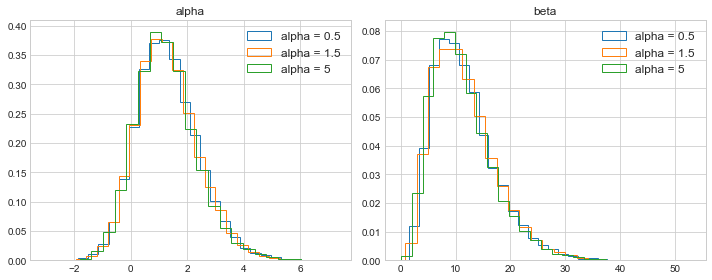

In [19]:
# plot the histograms of the alphas
fig, ax = plt.subplots(1, 2, figsize=(10, 4));

for i, a in enumerate(alphas):
    ax[0].hist(tr.get_values('alpha', chains=i), histtype='step', bins=25, density=True, label='alpha = {}'.format(a))
    ax[0].set_title('alpha')
    
    ax[1].hist(tr.get_values('beta', chains=i), histtype='step', bins=25, density=True, label='alpha = {}'.format(a))
    ax[1].set_title('beta')

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
plt.tight_layout()

### Answer 3.6

Yes, convergence is observed as the histrgrams of different traces of $\alpha$'s and $\beta$'s look similar.

---

***Obtaining the posterior predictive***:  Since this is a regression, the posterior predictive $p(y^{\ast} \mid x^{\ast}, D)$ is now obtained at each of our doses. If we had stored our burnin-removed traces in the variable `tr1`, then the following code will give use a posterior predictive of shape `(num_samples_in_trace, num_data)`.

In [20]:
with bioassay_model:
    deaths_sim = pm.sample_ppc(trace)

100%|██████████| 50000/50000 [00:38<00:00, 1284.33it/s]


In [21]:
deaths_sim['obs_deaths'].shape

(50000, 4)

But of course, what we want is being able to predict observations at new doses. We can create an array of new hypothetical doses:

In [22]:
log_dose_to_predict = np.random.uniform(-0.8, 0.7, size=50)
n_predict = n = 5 * np.ones(50, dtype=int)

print(log_dose_to_predict.shape, n_predict.shape)

(50,) (50,)


We now update the values of the shared theano variables we had created with the values for which we want to predict:

In [23]:
# Changing values here will also change values in the model
log_dose_shared.set_value(log_dose_to_predict) # data changed
n_shared.set_value(n_predict) # n changed

Now, simply running `sample_ppc` will give us posterior-predictive samples at 50 doses. Do this, restricting ourselves to getting only 5000 samples at each dosage, rather than the `num_samples_in_trace` we would get otherwise. The shape of the output should be 5000x50. Plot the predictive at 2-3 points on the dosage grid.

3.7. Plot the posterior predictive means against the dosage grid `log_dose_to_predict` we used above. Use `np.percentile` to get the 95% credible interval on the predictive at each dosage, and use this to plot errorbars. Plot the observed data and provide an interpretation of the results.

In [24]:
# 3.7 draw 5000 pp samples
with bioassay_model:
    deaths_sim_pp = pm.sample_ppc(trace, samples=5000)

100%|██████████| 5000/5000 [00:05<00:00, 945.14it/s] 


In [25]:
# index of log_dose at min, max and the position closest to 0
np.argmin(log_dose_to_predict), np.argmax(log_dose_to_predict), np.argmin(np.abs(log_dose_to_predict))

(2, 48, 16)

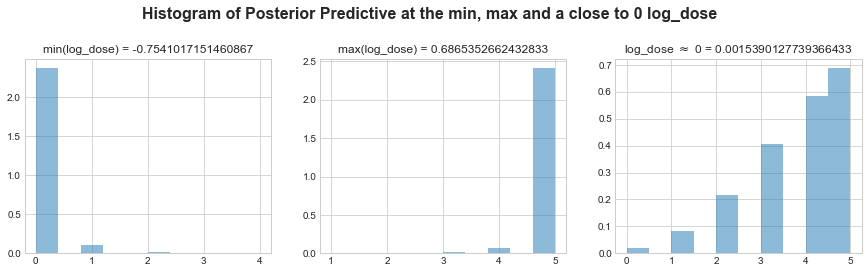

In [40]:
# plot histogram of pp on 3 points of `log_does_interested`
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
plt.suptitle('Histogram of Posterior Predictive at the min, max and a close to 0 log_dose', fontsize=16, weight='heavy')
plt.subplots_adjust(top=0.8)

ax[0].hist(deaths_sim_pp['obs_deaths'][:, np.argmin(log_dose_to_predict)], alpha=0.5, density=True)
ax[1].hist(deaths_sim_pp['obs_deaths'][:, np.argmax(log_dose_to_predict)], alpha=0.5, density=True)
ax[2].hist(deaths_sim_pp['obs_deaths'][:, np.argmin(np.abs(log_dose_to_predict))], alpha=0.5, density=True)

ax[0].set_title('min(log_dose) = {}'.format(log_dose_to_predict[np.argmin(log_dose_to_predict)]))
ax[1].set_title('max(log_dose) = {}'.format(log_dose_to_predict[np.argmax(log_dose_to_predict)]))
ax[2].set_title(r'log_dose $\approx$ 0 = {}'.format(log_dose_to_predict[np.argmin(np.abs(log_dose_to_predict))]))
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

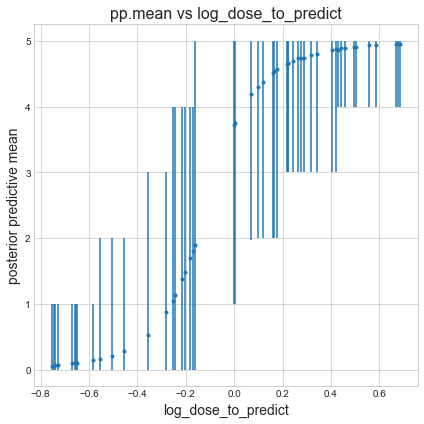

In [41]:
pp_975 = np.percentile(deaths_sim_pp['obs_deaths'], 97.5, axis=0)
pp_025 = np.percentile(deaths_sim_pp['obs_deaths'], 2.5, axis=0)  
pp_mean = np.mean(deaths_sim_pp['obs_deaths'], axis=0)

# plot pp.mean vs log_dose_to_predict
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.scatter(log_dose_to_predict, y=deaths_sim_pp['obs_deaths'].mean(axis=0), s=8)
ax.errorbar(x=log_dose_to_predict, y=pp_mean, yerr=[pp_mean-pp_025, pp_975-pp_mean], linestyle='', marker='.')
ax.set_xlabel('log_dose_to_predict', fontsize=14)
ax.set_ylabel('posterior predictive mean', fontsize=14)
ax.set_title('pp.mean vs log_dose_to_predict', fontsize=16)
plt.tight_layout()

### Answer 3.7

**Interpretation on the posterior predictive means**: 
- The 95% CI's are wide for `log_dose_to_predict` $\approx$ 0 but narrow for `log_dose_to_predict` at the ends. This is because the data of `log_dose_to_predict` was generated from a uniform distribution on $[-0.8, 0.7]$, and the inverse logit (sigmoid) function was used as the activation by logistic regression which has smaller slope at the ends of x and larger slopes for x in the middle.
- In general, the posterior predictive means positively correlate with `log_dose_to_predict`, which is consistent with positive estimates of $\beta$
- The range of posterior predictive is $[0, 5]$.

---

**Gratuitous Titular Reference**:  The [I say, I say, boy!](https://knowyourmeme.com/photos/605281-reaction-images) meme is the perfect mix of meme and [Foghorn Leghorn](https://en.wikipedia.org/wiki/Foghorn_Leghorn).  Of course there are [many](https://knowyourmeme.com/photos/1265646-jeff-sessions) [others](https://knowyourmeme.com/photos/992404-whoosh-you-missed-the-joke).

<div class="answer-separator">
------------------------
</div>